In [5]:
import pandas as pd
import gensim
import spacy
import nltk

import pyLDAvis
import pyLDAvis.gensim

from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from pprint import pprint

In [6]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# add: be, have, is, do, th, re
extra_words = ['be', 'have', 'is', 'do', 'th', 're']
for item in extra_words:
    stop_words.append(item) # yes there's probably a better way of doing it but i am lazy
len(stop_words)

185

In [7]:
source_path = '/mnt/storage/TopicModels/russian-troll-tweets-master/IRAhandle_tweets_'

In [8]:
df_1 = pd.read_csv(source_path+str(1)+'.csv')

In [9]:
df_1.head()

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,NaN,Right,0,0,RightTroll
1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,NaN,Right,0,0,RightTroll
2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,RETWEET,Right,0,1,RightTroll
3,9.060000e+17,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,NaN,Right,0,0,RightTroll
4,9.060000e+17,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,RETWEET,Right,0,1,RightTroll


In [10]:
df_1["region"].unique()

array(['Unknown', nan, 'United States', 'Italy', 'United Arab Emirates',
       'Japan', 'Israel', 'Azerbaijan', 'Egypt', 'United Kingdom',
       'Russian Federation', 'Turkey', 'Iraq', 'Germany', 'France',
       'Ukraine', 'Serbia', 'Hong Kong', 'Austria', 'Belarus'],
      dtype=object)

From SocialStudio  https://help.salesforce.com/articleView?id=000199367&type=1

## Region classification for Tweets

Tweets are classified at the Tweet level. The regions for multiple Tweets from the same Twitter user can be different. 

In order of precedence, the region of a Tweet is determined using the following information:

1. Geographical coordinates

The geographical coordinates are provided when the user enables the Tweet location feature. The device used to Tweet, such as the mobile phone, controls which geographical coordinates are provided. Find more information in FAQs about the Tweet location feature and Adding your location to a Tweet.
 

2. Location listed in the user's profile

Users enter their location in a free form text box. Depending on the text entered, this information may be used to set their region. For example, "Canada" can be used to set a region, but "my hometown" cannot.
 

3. Time zone set by the user in their Twitter account settings.

Although Tweets are classified at the Tweet level, author-level data is still stored in the system. When the first Tweet from a Twitter Author is saved, the region of that Tweet is used as the default region for the Twitter Author moving forward.

Note: Region data can appear unavailable or ambiguous for a Tweet or Twitter Author. If a Tweet is ingested for an existing Twitter Author and the region information is unavailable or ambiguous for that particular Tweet, the Tweet will be classified using the default region for the Twitter Author. For any Tweets from new Twitter Authors with missing or ambiguous region data, the Tweet will be classified with the region 'Unknown'. 



In [11]:
main_df = pd.DataFrame()

In [12]:
# Read in data, filter and then get rid of the original data frame. Append new data frame using concat

for i in range(1, 10):
    fileo = source_path + str(i)+'.csv'
    print(fileo)
    df = pd.read_csv(fileo)
    filtero = df['region']=="United Kingdom"
    df2 = df[filtero]
    main_df = pd.concat([main_df, df2])
    
# write a function to do this

/mnt/storage/TopicModels/russian-troll-tweets-master/IRAhandle_tweets_1.csv
/mnt/storage/TopicModels/russian-troll-tweets-master/IRAhandle_tweets_2.csv
/mnt/storage/TopicModels/russian-troll-tweets-master/IRAhandle_tweets_3.csv
/mnt/storage/TopicModels/russian-troll-tweets-master/IRAhandle_tweets_4.csv
/mnt/storage/TopicModels/russian-troll-tweets-master/IRAhandle_tweets_5.csv
/mnt/storage/TopicModels/russian-troll-tweets-master/IRAhandle_tweets_6.csv
/mnt/storage/TopicModels/russian-troll-tweets-master/IRAhandle_tweets_7.csv
/mnt/storage/TopicModels/russian-troll-tweets-master/IRAhandle_tweets_8.csv
/mnt/storage/TopicModels/russian-troll-tweets-master/IRAhandle_tweets_9.csv


In [13]:
len(main_df)

18062

In [14]:
main_df["region"].unique()

array(['United Kingdom'], dtype=object)

In [15]:
import re

I decided to remove retweets and quote tweets to narrow things down. These probably give some information, but I wanted to look at the primary tweets on their own as they would have taken the most effort.

In [16]:
# get rid of retweets
main_df_filtered= main_df[main_df["post_type"]!='RETWEET']

In [17]:
# get rid of quote tweets
main_df_filtered= main_df_filtered[main_df_filtered["post_type"]!='QUOTE_TWEET']

In [19]:
# Remove Emails
main_df_filtered["content"] = main_df_filtered["content"].str.replace('\\S*@\\S*\\s?', '')
#conveniently also removed twitter handles
# function

In [20]:
print(stop_words)


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [21]:
# Remove newline characters
main_df_filtered["content"] = main_df_filtered["content"].str.replace(r'\s+', ' ')

# Remove web addresses
main_df_filtered["content"] = main_df_filtered["content"].str.replace(r'\w*:\/\/\S*', '') 
#note: find out what caused the deprecation warning and also which regex worked

# function these

In [22]:
main_df.iloc[6,2]

'rank more Boost #UnlikelyMagic8BallAnswers https://t.co/7Nf56OM66v'

In [35]:
main_df_filtered.iloc[6,2] # success

'rank more Boost #UnlikelyMagic8BallAnswers '

In [36]:
# filtering to retain only the tweets in english
engfilt = main_df_filtered['language']=='English'
main_df_filtered = main_df_filtered[engfilt]

In [38]:
raw_data_file = 'tweets1.txt' # file to write the raw (well, filtered, partially processed) data to

In [51]:
for index, item in main_df_filtered["content"].iteritems():
    with open(raw_data_file, 'a') as f:
        f.write(str(item)+ '\n') # is there a more efficient way of doing this?

In [39]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

/home/katie/anaconda3/lib/python3.6/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/home/katie/anaconda3/lib/python3.6/site-packages/msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]
/home/katie/anaconda3/lib/python3.6/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/home/katie/anaconda3/lib/python3.6/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/home/ka

In [40]:
#Preprocessing function- apply to df or to MyDocs class?
# [tokenize -- lowercase -- remove punctuation]<simple_preprocess -- remove stopwords --  [remove very short words]s_p
# [-- POS tag and remove -- lemmatize]  -- remove numbers[dealt with by lemmatization]
# could you run the files through and write straight to file? then the preprocessing would need to be applied to all the 
# data in stream format, hence removing emails and web addresses etc would need to be done in the pipeline
# could stream data from one file to another. how to retain document-per-line form?
# simple_preprocess will tokenize, remove punctuation and discard anything shorter than 2 (set this option to 3) and 
# longer than 15

# read in -- process -- write out to file

# Define functions for stopwords and lemmatization- keep these functions
def remove_stopwords(texts):
    return [word for word in simple_preprocess(str(texts)) if word not in stop_words] 

def preprocess(doc):
    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
    no_stops = remove_stopwords(doc)
    texts_out = []
    doc = nlp(doc)
    texts_out.append([ token.lemma_ for token in doc if token.pos_ in allowed_postags and token.lemma_ not in ["-pron-", "#"] ]) # what happens if you sub [ for (?
    
    return texts_out

# need to get rid of -PRON- and # as words


In [1]:
# Misspellings will be a problem perhaps. How best to deal with? Maybe don't automatically distrust Hunspell- test it out

In [54]:
processed_text_file = "processed_text_file.txt"

In [58]:
def file_stream_preprocess(raw_data_file, processed_text_file):
    with open(raw_data_file, 'r') as rawf:
        newf = open(processed_text_file, 'a')
        for line in rawf:
            processed_line = preprocess(line)
            newf.write(str(processed_line).strip('[]')+'\n')
        newf.close()        
    return newf


In [62]:
import timeit

In [63]:
tic = timeit.default_timer()
file_stream_preprocess(raw_data_file, processed_text_file)
toc = timeit.default_timer()
toc-tic

165.9094397580002

This will return the elapsed wall clock (real) time, not CPU time. And as described in the timeit documentation chooses the most precise available real-world timer depending on the platform.

ALso, beginning with Python 3.3 this same functionality is available with the time.perf_counter performance counter. Under 3.3+ timeit.default_timer() refers to this new counter.

For more precise/complex performance calculations, timeit includes more sophisticated calls for automatically timing small code snippets including averaging run time over a defined set of repetitions.

It has written it differently than before now that it is a function, also has not removed "-PRON-"

In [64]:
processed_text = "processed_text.txt"

In [65]:
tic = timeit.default_timer()
with open(raw_data_file, 'r') as rawf:
        newf = open(processed_text, 'a')
        for line in rawf:
            processed_line = preprocess(line)
            newf.write(str(processed_line).strip('[]')+'\n')
        newf.close()
toc = timeit.default_timer()

toc - tic

168.58842722300005

this took 3 more seconds, although that is probably negligible because it is measuring real time

In [66]:
class MyDocs(object):
    def __init__(self, file):
        self.file = file
    def __iter__(self):
        for line in open(self.file, 'r'):  
            yield gensim.utils.simple_preprocess(str(line), deacc=True)

In [67]:
docs = MyDocs(processed_text)
# successful iterator item
# or maybe use one of the built-in corpus functions?

In [68]:
dictionary = Dictionary(docs)
# shows that dictionary can take an iterator

In [69]:
print(dictionary.token2id)

{'ballanswer': 0, 'identical': 1, 'live': 2, 'pron': 3, 'scrotum': 4, 'time': 5, 'twin': 6, 'unlikelymagic': 7, 'whom': 8, 'ball': 9, 'dis': 10, 'new': 11, 'who': 12, 'all': 13, 'fish': 14, 'long': 15, 'so': 16, 'thank': 17, 'at': 18, 'cry': 19, 'follow': 20, 'get': 21, 'sleep': 22, 'then': 23, 'shit': 24, 'basement': 25, 'door': 26, 'lock': 27, 'mind': 28, 'never': 29, 'lawyer': 30, 'answer': 31, 'be': 32, 'block': 33, 'learn': 34, 'more': 35, 'view': 36, 'insert': 37, 'quater': 38, 'better': 39, 'safe': 40, 'sorry': 41, 'animal': 42, 'kind': 43, 'first': 44, 'let': 45, 'smoke': 46, 'call': 47, 'mom': 48, 'word': 49, 'light': 50, 'need': 51, 'off': 52, 'words': 53, 'smile': 54, 'stream': 55, 'video': 56, 'affiliation': 57, 'political': 58, 'what': 59, 'cattle': 60, 'hand': 61, 'prod': 62, 'ask': 63, 'how': 64, 'lubricant': 65, 'there': 66, 'friend': 67, 'hot': 68, 'say': 69, 'smell': 70, 'pasttensesong': 71, 'top': 72, 'nigga': 73, 'badass': 74, 'empty': 75, 'go': 76, 'show': 77, 'sou

In [70]:
class MyCorpus:
    def __iter__(self):
        for item in docs:
            yield dictionary.doc2bow(item)

In [71]:
corpus = MyCorpus()

In [72]:
bigram = gensim.models.Phrases(docs, min_count=5, threshold=100)

In [73]:
trigram = gensim.models.Phrases(bigram[docs], threshold=100)  

/home/katie/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Have not actually used the bigrams and trigrams in this model

In [75]:
tic1 = timeit.default_timer()
bigram_mod = gensim.models.phrases.Phraser(bigram)
toc1 = timeit.default_timer()
print(toc1 - tic1)

tic2 = timeit.default_timer()
trigram_mod = gensim.models.phrases.Phraser(trigram)
toc2 = timeit.default_timer()

print(toc2 - tic2)

0.6754899980005575
0.6704302939997433


In [76]:
tic = timeit.default_timer()
# Build LDA model from your garbage input
# input is no longer garbage!
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=30, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
toc = timeit.default_timer()
toc - tic

163.91896347000056

In [77]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())


[(29,
  '0.053*"again" + 0.051*"head" + 0.049*"front" + 0.048*"face" + '
  '0.041*"building" + 0.040*"training" + 0.030*"could" + 0.025*"responsible" + '
  '0.024*"old" + 0.019*"where"'),
 (11,
  '0.118*"rocket" + 0.095*"vehicle" + 0.085*"seize" + 0.067*"start" + '
  '0.045*"down" + 0.023*"burn" + 0.023*"past" + 0.020*"authority" + '
  '0.020*"hand" + 0.019*"dealer"'),
 (16,
  '0.091*"meet" + 0.079*"plan" + 0.068*"can" + 0.062*"begin" + 0.043*"least" + '
  '0.030*"top" + 0.023*"centre" + 0.020*"reject" + 0.019*"unknown" + '
  '0.018*"thousand"'),
 (24,
  '0.243*"more" + 0.062*"leave" + 0.027*"deploy" + 0.025*"sign" + '
  '0.025*"defense" + 0.023*"what" + 0.022*"build" + 0.021*"know" + '
  '0.021*"feature" + 0.019*"erdogan"'),
 (9,
  '0.133*"operation" + 0.124*"commander" + 0.088*"arrive" + 0.081*"base" + '
  '0.048*"breach" + 0.040*"retake" + 0.027*"pilot" + 0.023*"message" + '
  '0.022*"territory" + 0.021*"as"'),
 (5,
  '0.224*"new" + 0.143*"fire" + 0.029*"round" + 0.026*"get" + 0.020

In [282]:
# convert corpus to mm format
corpora.MmCorpus.serialize('/mnt/storage/TopicModels/tweetcorpus.mm', corpus)

In [78]:
corpus_file = '/mnt/storage/TopicModels/tweetcorpus.mm'
loaded_corpus = corpora.MmCorpus(corpus_file)

In [79]:
# Visualize the topics
tic = timeit.default_timer()
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, loaded_corpus, dictionary)
toc = timeit.default_timer()
vis

/home/katie/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
14     8.041823        1       1 -0.300926  0.347972
21     6.853078        1       2 -0.176814 -0.247155
6      4.763886        1       3 -0.134119 -0.137466
13     4.522020        1       4 -0.092073 -0.068282
27     4.013026        1       5 -0.060138 -0.044489
2      3.979994        1       6 -0.037680 -0.031000
22     3.979779        1       7 -0.054408 -0.040804
0      3.941050        1       8 -0.068848 -0.058378
10     3.940099        1       9 -0.056241 -0.034968
3      3.857891        1      10 -0.019998 -0.014522
18     3.588212        1      11 -0.045806 -0.016363
20     3.248350        1      12  0.013564  0.003352
7      3.039379        1      13  0.005968  0.003408
8      2.864196        1      14  0.038549  0.009287
15     2.859544        1      15  0.032684  0.008438
17     2.807644        1      16  0.040305  0.016299
1      2.789150        1      17  0.052327  0.019332
25     2.784909        1      18  0.042215  0.016308
26     2.748111        1      19  0.042032  0.010806
19     2.727916        1      20  0.037624  0.014099
4      2.706194        1      21  0.032451  0.015480
23     2.445631        1      22  0.062074  0.016743
5      2.388100        1      23  0.086889  0.025917
12     2.375149        1      24  0.063474  0.017520
28     2.360155        1      25  0.073238  0.023069
9      2.302974        1      26  0.060228  0.022385
16     2.147956        1      27  0.091525  0.027995
24     2.122456        1      28  0.089241  0.029853
11     2.046084        1      29  0.079833  0.030931
29     1.755242        1      30  0.102833  0.034232, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
32    Default  3273.000000           be  3273.000000  30.0000  30.0000
373   Default  1212.000000         kill  1212.000000  29.0000  29.0000
583   Default   797.000000       attack   797.000000  28.0000  28.0000
1291  Default   745.000000    terrorist   745.000000  27.0000  27.0000
921   Default   961.000000       syrian   961.000000  26.0000  26.0000
3     Default   703.000000         pron   703.000000  25.0000  25.0000
924   Default   708.000000      capture   708.000000  24.0000  24.0000
1074  Default   609.000000        force   609.000000  23.0000  23.0000
129   Default   590.000000         have   590.000000  22.0000  22.0000
951   Default   637.000000      turkish   637.000000  21.0000  21.0000
340   Default   439.000000      russian   439.000000  20.0000  20.0000
1041  Default   509.000000      village   509.000000  19.0000  19.0000
11    Default   405.000000          new   405.000000  18.0000  18.0000
35    Default   390.000000         more   390.000000  17.0000  17.0000
942   Default   443.000000        clash   443.000000  16.0000  16.0000
654   Default   531.000000        rebel   531.000000  15.0000  15.0000
332   Default   411.000000         take   411.000000  14.0000  14.0000
1219  Default   353.000000    airstrike   353.000000  13.0000  13.0000
983   Default   366.000000     militant   366.000000  12.0000  12.0000
91    Default   331.000000          not   331.000000  11.0000  11.0000
1130  Default   322.000000       target   322.000000  10.0000  10.0000
1499  Default   348.000000      control   348.000000   9.0000   9.0000
1019  Default   358.000000        iraqi   358.000000   8.0000   8.0000
807   Default   319.000000         area   319.000000   7.0000   7.0000
1079  Default   333.000000       border   333.000000   6.0000   6.0000
153   Default   352.000000        claim   352.000000   5.0000   5.0000
69    Default   331.000000          say   331.000000   4.0000   4.0000
937   Default   344.000000          aid   344.000000   3.0000   3.0000
913   Default   427.000000         city   427.000000   2.0000   2.0000
1027  Default   343.000000      destroy   343.000000   1.000

Well that turned out pretty crappy- most of the topics have way too much overlap, and even those that seem far away are basically about the same things. <br>
  I ran another model anyway using Mallet as a learning experience. It performed even worse than the first! <br>
  After digging into the data a little bit, it turned out that this is because there are really only two topics in it: random crap, and the Middle  East. Obviously there will be subtopics within this, but they might be too subtle for the algorithm to make sense of.<br>
  I decided to manually divide up the data some more- knowing the proportions of random crap to Middle East would at least give us some ideas.

In [80]:
toc - tic

4.15600662199995

In [81]:
len(main_df_filtered) # 15475 tweets

15475

In [83]:
from gensim.models import CoherenceModel

In [87]:
# Compute perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) # the lower the better

# Compute coherence score

coherence_model_lda = CoherenceModel(model=lda_model, texts=docs,  dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.498190382504504

Coherence Score:  0.592554843575262


In [91]:
mallet_path = '/mnt/storage/TopicModels/mallet-2.0.8/bin/mallet' # would need to alter obvs

In [92]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=dictionary)

In [93]:
# Show topics
pprint(ldamallet.show_topics(formatted=False))

# Compute coherence score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(15,
  [('attack', 0.2121390689451974),
   ('terrorist', 0.1502651738361815),
   ('kill', 0.10489098408956983),
   ('civilian', 0.08956982911019445),
   ('injure', 0.06894519740718916),
   ('rocket', 0.046552740129640544),
   ('bombing', 0.024160282852091926),
   ('repel', 0.023276370064820272),
   ('woman', 0.019740718915733646),
   ('child', 0.016499705362404242)]),
 (9,
  [('syrian', 0.28734216199568835),
   ('government', 0.05913150600554358),
   ('official', 0.03880505081613797),
   ('meet', 0.03295349553433939),
   ('refugee', 0.03233754234678164),
   ('anti', 0.028333846627656298),
   ('visit', 0.027717893440098552),
   ('opposition', 0.02740991684631968),
   ('iranian', 0.020326455189405606),
   ('delegation', 0.018170619032953497)]),
 (13,
  [('capture', 0.18146603098927294),
   ('village', 0.14958283671036948),
   ('claim', 0.0697258641239571),
   ('advance', 0.05780691299165673),
   ('hom', 0.04558998808104887),
   ('south', 0.0432061978545888),
   ('east', 0.04141835518474

In [94]:
# lower coherence score

In [95]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various numbers of topics
    
    Parameters:
    -----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max number of topics
    
    Returns:
    --------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

In [105]:
tic = timeit.default_timer()

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=60, step=6)

toc = timeit.default_timer()

toc - tic # nearly 5 minutes for 40- not too bad 7 minutes for 60

417.8294642159999

In [106]:
417/60

6.95

In [99]:
import matplotlib.pyplot as plt

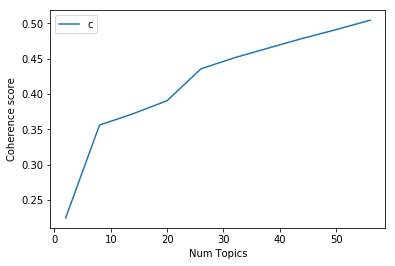

In [107]:
# Show graph
limit=60; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc="best")
plt.show()

In [108]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2245
Num Topics = 8  has Coherence Value of 0.3558
Num Topics = 14  has Coherence Value of 0.372
Num Topics = 20  has Coherence Value of 0.3903
Num Topics = 26  has Coherence Value of 0.4354
Num Topics = 32  has Coherence Value of 0.4512
Num Topics = 38  has Coherence Value of 0.4649
Num Topics = 44  has Coherence Value of 0.4784
Num Topics = 50  has Coherence Value of 0.4909
Num Topics = 56  has Coherence Value of 0.5042


In [115]:
# Select the model and print the topics
optimal_model = model_list[9]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(15,
  '0.203*"city" + 0.109*"eastern" + 0.102*"neighborhood" + 0.071*"recapture" + '
  '0.060*"part" + 0.036*"side" + 0.030*"militant" + 0.020*"drive" + '
  '0.019*"manage" + 0.019*"western"'),
 (32,
  '0.327*"clash" + 0.136*"rebel" + 0.091*"fierce" + 0.078*"heavy" + '
  '0.039*"ongoing" + 0.037*"vicinity" + 0.037*"axis" + 0.027*"loss" + '
  '0.021*"renew" + 0.020*"inflict"'),
 (7,
  '0.079*"open" + 0.077*"front" + 0.064*"road" + 0.054*"supply" + 0.053*"line" '
  '+ 0.044*"cut" + 0.038*"power" + 0.035*"plant" + 0.033*"water" + '
  '0.033*"route"'),
 (53,
  '0.124*"refugee" + 0.083*"break" + 0.066*"camp" + 0.051*"training" + '
  '0.047*"migrant" + 0.036*"follow" + 0.035*"recruit" + 0.031*"siege" + '
  '0.029*"trap" + 0.029*"kid"'),
 (44,
  '0.204*"rebel" + 0.172*"back" + 0.169*"town" + 0.039*"ground" + 0.031*"push" '
  '+ 0.031*"key" + 0.022*"islamist" + 0.020*"stronghold" + 0.019*"reportedly" '
  '+ 0.017*"hundred"'),
 (8,
  '0.324*"force" + 0.322*"iraqi" + 0.054*"retake" + 0.046*"st

In [113]:
len(model_list)

10

In [125]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc contribution and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round (prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
                
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
    # Add original text to the end of the output
    texts = []
    for item in main_df_filtered["content"]:
        texts.append(item) # deal with streamed corpus by creating the list we wanted to avoid in the first place
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return (sent_topics_df)

In [126]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=docs)

In [127]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Key words', 'Text']

# Show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Key words,Text
0,0,42.0,0.0460,"weapon, seize, arm, destroy, center, attempt, ...","My identical twin Irwin, with whom I lived for..."
1,1,42.0,0.0680,"weapon, seize, arm, destroy, center, attempt, ...","#UnlikelyMagic8BallAnswers New ball, who dis?"
2,2,42.0,0.0536,"weapon, seize, arm, destroy, center, attempt, ...","So long, and thanks for all the fish. #Unlikel..."
3,3,42.0,0.0517,"weapon, seize, arm, destroy, center, attempt, ...","Follow her on Instagram, get her Snap, then cr..."
4,4,42.0,0.0525,"weapon, seize, arm, destroy, center, attempt, ...",Google that shit!! #UnlikelyMagic8BallAnswers


In [133]:
df_dominant_topic.to_csv('/mnt/storage/TopicModels/df_dominant_topic.csv')

In [128]:
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby("Dominant_Topic")

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1365,"pron, day, start, school, high, watch, student...",190 thousand high school students start to tak...
1,1.0,0.0805,"village, capture, liberate, west, expel, south...","Rock the goat, don't rock the goat baby, rock ..."
2,2.0,0.1071,"fire, set, exchange, rate, usd, zone, deal, ag...",CBS sets intervention exchange price to SYP 47...
3,3.0,0.1071,"airstrike, carry, coalition, warplane, conduct...",US-led coalition jets carried out several airs...
4,4.0,0.1093,"turkish, border, tank, cross, lebanese, pm, bu...",#Turkish Army begins amassing troops and tanks...
5,5.0,0.1170,"aid, humanitarian, convoy, family, enter, dist...",3 tons of Russian humanitarian aid distributed...
6,6.0,0.1131,"video, show, release, find, mass, execution, b...",#Iraq \| New #ISIS video ‘Hell of the Apostate...
7,7.0,0.1319,"open, front, road, supply, line, cut, power, p...",Australian boxing team conducts friendly match...
8,8.0,0.0834,"force, iraqi, retake, storm, special, black, b...",#Iraq \| Iraqi security forces (#ISF) are stor...
9,9.0,0.0959,"people, leave, evacuate, celebrate, batch, win...",Syria’s Ghazal wins the high jump bronze medal...


In [134]:
sent_topics_sorteddf_mallet.to_csv('/mnt/storage/TopicModels/sent_topics_sorteddf_mallet.csv')

In [129]:
# Number of Documents for each topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate column-wise 
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1) # not worked?

# Change column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

#Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,42.0,"weapon, seize, arm, destroy, center, attempt, ...",1218.0,0.0787
1,42.0,"weapon, seize, arm, destroy, center, attempt, ...",337.0,0.0218
2,42.0,"weapon, seize, arm, destroy, center, attempt, ...",293.0,0.0189
3,42.0,"weapon, seize, arm, destroy, center, attempt, ...",427.0,0.0276
4,42.0,"weapon, seize, arm, destroy, center, attempt, ...",395.0,0.0255
5,42.0,"weapon, seize, arm, destroy, center, attempt, ...",323.0,0.0209
6,42.0,"weapon, seize, arm, destroy, center, attempt, ...",290.0,0.0187
7,42.0,"weapon, seize, arm, destroy, center, attempt, ...",335.0,0.0216
8,42.0,"weapon, seize, arm, destroy, center, attempt, ...",235.0,0.0152
9,42.0,"weapon, seize, arm, destroy, center, attempt, ...",310.0,0.0200


In [130]:
grouped = df_dominant_topics.groupby('Dominant_Topic')

In [135]:
df_dominant_topics.to_csv('/mnt/storage/TopicModels/df_dominant_topics.csv')

In [143]:
main_df_filtered['content'] = main_df_filtered['content'].str.lower()

In [145]:
len(main_df_filtered[main_df_filtered['content'].str.contains('aleppo')])

1467

In [167]:
len(main_df_filtered[main_df_filtered['content'].str.contains('syria')])

3763

In [155]:
len(main_df_filtered[main_df_filtered['content'].str.contains('homs')])

582

In [149]:
len(main_df_filtered[main_df_filtered['content'].str.contains('damascus')])

667

In [162]:
len(main_df_filtered[main_df_filtered['content'].str.contains('isis|islamicstate|#is|daesh|islamic state|isil')]) #alquaeda jihad/i

4134

In [151]:
len(main_df_filtered[main_df_filtered['content'].str.contains('raqqa')])

642

In [152]:
len(main_df_filtered[main_df_filtered['content'].str.contains('iran')])

374

In [154]:
len(main_df_filtered[main_df_filtered['content'].str.contains('russia|russian')])

959

In [156]:
len(main_df_filtered[main_df_filtered['content'].str.contains('migrant|refugees|refugee')])

308

In [ ]:
# ghouta hasaka daraa palmyra latakia deirezzor hama # assad fsa saa

In [ ]:
# ramadi mosul fallujah

In [ ]:
# hizbullah hezbollah

In [159]:
len(main_df_filtered[main_df_filtered['content'].str.contains('')])

0

In [160]:
len(main_df_filtered[main_df_filtered['content'].str.contains('ypg')])

186

Turkish ones look interesting- possible to extract partial strings (e.g. turk*- would pick up #Turkish_Inquisition, for example)

In [168]:
len(main_df_filtered[main_df_filtered['content'].str.contains('jihad')])

164

In [169]:
len(main_df_filtered[main_df_filtered['content'].str.contains('syria|aleppo|raqqa|homs|ghouta|hasaka|daraa|palmyra|deirezzor|hama|assad|fsa|saa')])

7463

In [170]:
len(main_df_filtered[main_df_filtered['content'].str.contains('russia') & main_df_filtered['content'].str.contains('syria')])

485

In [174]:
new_model = model_list[0]

In [175]:
df_topic_sents_keywords2 = format_topics_sentences(ldamodel=new_model, corpus=corpus, texts=docs)

In [176]:
# Format
df_dominant_topic2 = df_topic_sents_keywords2.reset_index()
df_dominant_topic2.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Key words', 'Text']

# Show
df_dominant_topic2.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Key words,Text
0,0,0.0,0.5000,"kill, pron, terrorist, attack, capture, villag...","my identical twin irwin, with whom i lived for..."
1,1,1.0,0.5185,"syrian, force, rebel, iraqi, russian, turkish,...","#unlikelymagic8ballanswers new ball, who dis?"
2,2,1.0,0.5185,"syrian, force, rebel, iraqi, russian, turkish,...","so long, and thanks for all the fish. #unlikel..."
3,3,0.0,0.5000,"kill, pron, terrorist, attack, capture, villag...","follow her on instagram, get her snap, then cr..."
4,4,1.0,0.5283,"syrian, force, rebel, iraqi, russian, turkish,...",google that shit!! #unlikelymagic8ballanswers


In [177]:
df_dominant_topic2.to_csv('/mnt/storage/TopicModels/df_dominant_topic_2.csv')